# Preprocesamiento de Datos #
- [Introducción](#Introduccion)
- [Gestión de datos faltantes](#Gestión-de-datos-faltantes)
    - [Identificación de valores faltantes en datos tabulares](#Identificación-de-valores-faltantes-en-datos-tabulares)
        - [Manejo conveniente de datos con DataFrames de pandas](#Manejo-conveniente-de-datos-con-DataFrames-de-pandas)
    - [Eliminar ejemplos o características de entrenamiento con valores faltantes](#Eliminar-ejemplos-o-características-de-entrenamiento-con-valores-faltantes)
    - [Introducir valores faltantes](#Introducir-valores-faltantes)
    - [Comprender el API estimador de scikit-learn](#Comprender-el-API-estimador-de-scikit-learn)
- [Gestión de datos categóricos](#Gestión-de-datos-categóricos)
    - [Codificación de datos categóricos con pandas](#Codificación-de-datos-categóricos-con-pandas)
        - [Mapeo de características ordinales](#Mapeo-de-características-ordinales)
        - [Codificación de etiquetas de clase](#Codificación-de-etiquetas-de-clase)
        - [Codificación one-hot en características nominales](#Codificación-one-hot-en-características-nominales)
        - [Codificación de características ordinales](#Opcional:-codificación-de-características-ordinales)
- [Particionado de un conjunto de datos en conjuntos de datos de entrenamiento y prueba separados](#Particionado-de-un-conjunto-de-datos-en-conjuntos-de-datos-de-entrenamiento-y-prueba-separados)
    - [Elegir una proporción adecuada para dividir un conjunto de datos en conjuntos de datos de entrenamiento y prueba](#Elegir-una-proporción-adecuada-para-dividir-un-conjunto-de-datos-en-conjuntos-de-datos-de-entrenamiento-y-prueba)
- [Conversión de las características a la misma escala](#Conversión-de-las-características-a-la-misma-escala)
    - [Normalización](#Normalización)
    - [Estadarización](#Estandarización)
        - [Normalización vs Estandarización](#Normalización-vs-Estandarización)
    - [Otros métodos de escalado](#Otros-métodos-de-escalado)
- [Selección de características significativas](#Selección-de-características-significativas)
    - [Regularización L1 y L2 como penalizaciones contra la complejidad del modelo](#Regularización-L1-y-L2-como-penalizaciones-contra-la-complejidad-del-modelo)
    - [Interpretación geométrica de la regularización de L2](#Interpretación-geométrica-de-la-regularización-de-L2)
    - [Soluciones dispersas con regularización L1](#Soluciones-dispersas-con-regularización-L1)
    - [Algoritmos secuenciales de selección de características](#Algoritmos-secuenciales-de-selección-de-características)

## Introducción ##
La calidad de los datos y la cantidad de información útil que contiene son factores clave que determinan la capacidad de aprendizaje de un algoritmo de aprendizaje automático. Por lo tanto, es absolutamente crítico asegurarse de que se examina y se preprocesa el conjunto de datos antes de alimentarlo a un algoritmo de aprendizaje.

Los temas que se van a ver son los siguientes:
- Eliminar e introducir valores perdidos del conjunto de datos
- Dar forma a datos categóricos poder utilizarlos en algoritmos de aprendizaje automático
- Seleccionar características relevantes para la construcción del modelo

## Gestión de datos faltantes ##
No es raro en las aplicaciones del mundo real que a los ejemplos de entrenamiento les falten uno o más valores por diversas razones. Desafortunadamente, la mayoría de las herramientas de procesamiento no son capaces de tratar esos valores faltantes, o bien, producirán resultados impredecibles si simplemente se ignoran. Por ello, es crucial que se traten esos valores faltantes antes de proceder con análisis posteriores.

### Identificación de valores faltantes en datos tabulares ###
Primero se crean datos de ejemplo con valores faltantes

In [1]:
import pandas as pd
from io import StringIO

In [2]:
csv_data = '''A,B,C,D
         1.0,2.0,3.0,4.0
         5.0,6.0,,8.0
         10.0,11.0,12.0,'''
df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


Para `DataFrames` grandes, puede ser tedioso buscar valores faltantes manualmente; en estos casos, se puede utilizar el método `isnull` para devolver un `DataFrame` con valores booleanos que indican si una celda contiene un valor numérico (`False`) o si faltan datos (`True`). Usando el método `sum`, se devuelve el número de valores faltantes por columna de la siguiente manera:

In [3]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

> ##### Manejo conveniente de datos con DataFrames de pandas #####
> Aunque scikit-learn se desarrolló originalmente para trabajar solo con matrices NumPy, a veces puede ser más conveniente preprocesar datos utilizando el `DataFrame` de pandas. Hoy en día, la mayoría de las funciones de scikit-learn admiten objetos `DataFrame` como parámetro, pero dado que el manejo de la matriz NumPy es más maduro en la API scikit-learn, se recomienda usar matrices NumPy cuando sea posible. Hay que tener en cuenta que **siempre se puede acceder a la matriz subyacente NumPy de un `DataFrame`** a través del atributo `values` antes de pasarlo a un estimador scikit-learn:

In [4]:
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

### Eliminar ejemplos o características de entrenamiento con valores faltantes ###
Una de las formas más fáciles de lidiar con los datos faltantes es simplemente **eliminar por completo las características** (columnas) o **ejemplos de entrenamiento** (filas) correspondientes del conjunto de datos; 

Las filas con valores perdidos pueden eliminarse fácilmente mediante el método `dropna`, pasandolo el valor $0$ (el indice de la fila) al parámetro `axis`:

In [5]:
df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


Del mismo modo, se puede eliminar columnas que tengan al menos un `NaN` en cualquier fila estableciendo el argumento de `axis` a $1$:

In [6]:
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


El método `dropna` admite varios parámetros adicionales que pueden ser útiles:
- Solo elimina las filas donde todas las columnas son NaN

In [7]:
df.dropna(how='all')

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


- Elimina las filas que tienen menos de 4 valores reales

In [8]:
df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


- Solo se eliminan las filas donde NaN aparezca en columnas específicas (aquí: 'C')

In [9]:
df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


Aunque la eliminación de datos faltantes parece ser un enfoque conveniente, también conlleva ciertas desventajas; por ejemplo, se puede terminar eliminando demasiadas muestras, lo que hará imposible un análisis confiable. O, si se eliminan demasiadas columnas de características, se corre el riesgo de perder información valiosa que el clasificador necesita para discriminar entre clases.

### Introducir valores faltantes ###
Cuando no es posible eliminar columnas de características porque se perderión datos valiosos, se puede utilizar diferentes técnicas de interpolación para estimar los valores faltantes a partir de otros ejemplos de entrenamiento del conjunto de datos. 

Una de las técnicas de interpolación más comunes es la **introducción de la media**, donde simplemente reemplazamos el valor faltante con el valor medio de toda la columna de características. Una forma conveniente de lograr esto es mediante el uso de la clase `SimpleImputer` de scikit-learn:

In [10]:
from sklearn.impute import SimpleImputer
import numpy as np

In [11]:
imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

Otras opciones para el parámetro de estrategia son `median` o `most_frequent`, que reemplaza los valores faltantes con los **valores medianos** y con los **valores más frecuentes**, respectivamente. Esta última estrategia es útil para introducir valores categóricos de características; por ejemplo, una columna de características que almacena una codificación de nombres de colores, como rojo, verde y azul.

Alternativamente, una forma aún más conveniente de introducir valores perdidos es utilizando el método `fillna` de pandas y proporcionando un método de entrada como argumento. Por ejemplo, usando pandas, se lograría la misma entrada de la media directamente en el objeto `DataFrame`

In [12]:
df.fillna(df.mean())

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,7.5,8.0
2,10.0,11.0,12.0,6.0


### Comprender el API estimador de scikit-learn ###
La clase `SimpleImputer` pertenece a las llamadas clases **transformador** en scikit-learn, que se utilizan para la transformación de datos. Los dos métodos esenciales de esos estimadores son `fit` y `transform`. El método de `fit` se usa para aprender los parámetros de transformación a partir de los datos de entrenamiento, y el método de `transform` usa esos parámetros para transformar los datos. Cualquier matriz de datos que se vaya a transformar debe tener el mismo número de características que la matriz de datos que se utilizó para adaptarse al modelo.

Es transformador se tiene que utilizar para transformar tanto el conjunto de datos de entrenamiento como el conjunto de datos de test.

![flujo transformador](imgs/flujo_transform.png)

Los clasificadores que se han utilizado hasta ahora pertenecen a los llamados **estimadores** en scikit-learn, con una API que es conceptualmente muy similar a los de las clases transformador. Los estimadores tienen un método `prediction` pero también pueden tener un método `transform`, que se verá más adelante. Como se recordará, también se utiliza el método `fit` para aprender los parámetros de un modelo cuando se entrena a estos estimadores para la clasificación. Sin embargo, en las tareas de aprendizaje supervisado, también proporcionamos las etiquetas de clase para ajustar el modelo, que luego se pueden utilizar para hacer predicciones sobre nuevos ejemplos de datos no etiquetados a través del método `predict`, como se ilustra en la siguiente figura:

![flujo estimador](imgs/flujo_estimador.png)

## Gestión de datos categóricos ##
Hasta ahora, solo se ha estado trabajando con valores numéricos. Sin embargo, no es raro que los conjuntos de datos del mundo real contengan una o más columnas de características categóricas.

Cuando se habla de datos categóricos, hay que distinguir aún más entre las características ordinales y nominales. Las características ordinales se pueden entender como valores categóricos que se pueden ordenar. En contraste, las características nominales no implican ningún orden.

### Codificación de datos categóricos con pandas ###
Sse va a ver las diferentes técnicas para manejar los datos categóricos.

#### Mapeo de características ordinales ####
Para asegurarse de que el algoritmo de aprendizaje interprete las características ordinales correctamente, se necesita convertir los valores de cadena categórica en enteros. Desafortunadamente, no hay una función adecuada que pueda derivar automáticamente el orden correcto de las características categóricas ordinales. Asi que se tiene que definir el mapeo de forma manual.

Primeros se crea un `DataFrame` que contenga datos categóricos

In [13]:
df = pd.DataFrame([
           ['verde', 'M', 10.1, 'clase2'],
           ['rojo', 'L', 13.5, 'clase1'],
           ['azul', 'XL', 15.3, 'clase2']])
df.columns = ['color', 'tamaño', 'precio', 'etiquetaclase']
df

,color,tamaño,precio,etiquetaclase
0,verde,M,10.1,clase2
1,rojo,L,13.5,clase1
2,azul,XL,15.3,clase2


El `DataFrame` recién creado contiene una característica nominal (`color`), una característica ordinal (`tamaño`) y una columna de característica numérica (`precio`). Las etiquetas de clase (suponiendo que creamos un conjunto de datos para una tarea de aprendizaje supervisada) se almacenan en la última columna.

En el siguiente ejemplo simple, se supone que se conoce la diferencia numérica entre las características, por ejemplo, $XL = L + 1 = M + 2$:

In [14]:
size_mapping = {'XL': 3,
                'L': 2,
                'M': 1}
df['tamaño'] = df['tamaño'].map(size_mapping)
df

,color,tamaño,precio,etiquetaclase
0,verde,1,10.1,clase2
1,rojo,2,13.5,clase1
2,azul,3,15.3,clase2


Si se quiere transformar los valores enteros de nuevo a la representación de cadena original en una etapa posterior, simplemente se puede definir un diccionario de mapeo inverso, que luego se puede usar a través del método de `map` de pandas en la columna de característica transformada

In [ ]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}
df['tamaño'].map(inv_size_mapping)

#### Codificación de etiquetas de clase ####
Muchas bibliotecas de aprendizaje automático requieren que las etiquetas de clase se codifiquen como valores enteros. Aunque la mayoría de los estimadores para la clasificación en scikit-learn convierten las etiquetas de clase a enteros internamente, se considera una buena práctica proporcionar etiquetas de clase como matrices de enteros para evitar problemas técnicos. Para codificar las etiquetas de clase, podemos usar un enfoque similar al mapeo de las características ordinales discutidas anteriormente. Hay que recordar que las etiquetas de clase no son ordinales, y no importa qué número entero asignemos a una etiqueta de cadena particular. Por lo tanto, podemos simplemente enumerar las etiquetas de clase, comenzando en $0$:

In [15]:
import numpy as np

In [16]:
class_mapping = {label: idx for idx, label in
                 enumerate(np.unique(df['etiquetaclase']))}
class_mapping

{'clase1': 0, 'clase2': 1}

Ahora, se puede utilizar el diccionario de mapeo para transformar las etiquetas de clase en enteros:

In [17]:
df['etiquetaclase'] = df['etiquetaclase'].map(class_mapping)
df

,color,tamaño,precio,etiquetaclase
0,verde,1,10.1,1
1,rojo,2,13.5,0
2,azul,3,15.3,1


Se puede invertir los pares clave-valor en el diccionario de mapeo de la siguiente manera para mapear las etiquetas de clase convertidas de nuevo a la representación de cadena original:

In [18]:
inv_class_mapping = {v: k for k, v in class_mapping.items()}
df['etiquetaclase'] = df['etiquetaclase'].map(inv_class_mapping)
df

,color,tamaño,precio,etiquetaclase
0,verde,1,10.1,clase2
1,rojo,2,13.5,clase1
2,azul,3,15.3,clase2


Alternativamente, hay una clase `LabelEncoder` implementada directamente en scikit-learn para lograr esto:

In [19]:
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
y = class_le.fit_transform(df['etiquetaclase'].values)
y

array([1, 0, 1])

Hay que tener en cuenta que el método `fit_transform` es solo un atajo para llamar a `fit` y `transform` por separado, y, además, se puede usar el método `inverse_transform` para transformar las etiquetas de clase entera de nuevo en su representación de cadena original:

In [20]:
class_le.inverse_transform(y)

array(['clase2', 'clase1', 'clase2'], dtype=object)

#### Codificación one-hot en características nominales ####
Como los estimadores de clasificación de scikit-learn tratan las etiquetas de clase como datos categóricos que no implican ningún orden (nominal), se ha utilizado `LabelEncoder` para codificar las etiquetas de cadena en enteros. Puede parecer que podríamos usar un enfoque similar para transformar el valor de características nominales:

In [21]:
X = df[['color', 'tamaño', 'precio']].values
color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:,0])
X

array([[2, 1, 10.1],
       [1, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

Si se para en este punto y se proporciona la matriz al clasificador, se cometerá uno de los errores más comunes al tratar con datos categóricos. Aunque los valores de color no aparecen en ningún orden en particular, un algoritmo de aprendizaje ahora asumirá que el `verde` es mayor que el `azul` y el `rojo` es mayor que el `verde`. Aunque esta suposición es incorrecta, el algoritmo aún podría producir resultados útiles. Sin embargo, esos resultados no serían óptimos.

Una solución común para este problema es utilizar una técnica llamada **codificación one-hot**. La idea detrás de este enfoque es crear una nueva característica ficticia para cada valor único en la columna de características nominales. Se pueden utilizar valores binarios (combinando las nuevas caracteristicas ficticias) para indicar el valor de la característica nominal en particular de un ejemplo; por ejemplo, un ejemplo `azul` se puede codificar como `azul=1`, `verde=0` y `rojo=0` (`100`). Para realizar esta transformación, podemos usar `OneHotEncoder` que se implementa en el módulo de `preprocesing` de scikit-learn:

In [22]:
from sklearn.preprocessing import OneHotEncoder
X = df[['color', 'tamaño', 'precio']].values
color_ohe = OneHotEncoder()
color_ohe.fit_transform(X[:, 0].reshape(-1, 1)).toarray()

array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]])

`X[:, 0]` retorna un array NumPy de una dimensión

`array(['verde', 'rojo', 'azul'], dtype=object)`. 

Al utilizar el método `reshape(-1,1)` lo convierte en una matriz con tantas filas como elementos haya (`-1`) en el original y una columna (`1`)

`array([['verde'],
       ['rojo'],
       ['azul']], dtype=object)`

De forma alternativa, se puede usar `ColumnTransformer` , que acepta una lista de tuplas `(name, transformer, column(s))`. El transformador `'passthrough'` sirve para dejar las columnas sin tocar.

In [23]:
from sklearn.compose import ColumnTransformer
X = df[['color', 'tamaño', 'precio']].values
c_transf = ColumnTransformer([
    ('onehot', OneHotEncoder(), [0]),
    ('nothing', 'passthrough', [1,2])
])
c_transf.fit_transform(X).astype(float)

array([[ 0. ,  0. ,  1. ,  1. , 10.1],
       [ 0. ,  1. ,  0. ,  2. , 13.5],
       [ 1. ,  0. ,  0. ,  3. , 15.3]])

Una forma aún más conveniente de crear esas características ficticias mediante una codificación one-hot es utilizar el método `get_dummies` implementado en pandas. Aplicado a un `DataFrame`, el método `get_dummies` solo convertirá columnas de cadena y dejará las demás columnas sin cambios:

In [24]:
pd.get_dummies(df[['precio', 'color', 'tamaño']])

,precio,tamaño,color_azul,color_rojo,color_verde
0,10.1,1,0,0,1
1,13.5,2,0,1,0
2,15.3,3,1,0,0


Cuando utilizamos conjuntos de datos de codificación one-shot, debemos tener en cuenta que esto introduce la multicolinealidad, que puede ser un problema para ciertos métodos (por ejemplo, métodos que requieren inversión de matrices). Si las características están altamente correlacionadas, las matrices son computacionalmente difíciles de invertir, lo que puede conducir a estimaciones numéricamente inestables. Para reducir la correlación entre las características, simplemente se puede eliminar una columna de características de la matriz codificada one-hot. Hay que apuntar que no se pierde ninguna información importante al eliminar una columna de características ficticia, el valor `0` en las caracteristicas ficticias restantes supone el valor `1` en la caracterisitica eliminada.

Si se utiliza la función `get_dummies`, se puede eliminar la primera columna pasando como argumento `True` al parámetro `drop_first`

In [25]:
pd.get_dummies(df[['precio', 'color', 'tamaño']],
               drop_first=True)

,precio,tamaño,color_rojo,color_verde
0,10.1,1,0,1
1,13.5,2,1,0
2,15.3,3,0,0


Para descartar una columna redundante a través de `OneHotEncoder`, es necesario establecer los parámetros `drop = 'first'` y `categories = 'auto'`

In [26]:
color_ohe = OneHotEncoder(drop='first', categories='auto')
c_transf = ColumnTransformer([
    ('onehot', color_ohe, [0]),
    ('nothing', 'passthrough', [1,2])
])
c_transf.fit_transform(X).astype(float)

array([[ 0. ,  1. ,  1. , 10.1],
       [ 1. ,  0. ,  2. , 13.5],
       [ 0. ,  0. ,  3. , 15.3]])

> ##### Opcional: codificación de características ordinales #####
> Si no se esta seguro acerca de las diferencias numéricas entre las categorías de características ordinales, o la diferencia entre dos valores ordinales no está definida, también se puede codificarlos usando una **codificación de umbral** con valores `0/1`. 

In [27]:
df2 = pd.DataFrame([['green', 'M', 10.1,
                    'class2'],
                   ['red', 'L', 13.5,
                    'class1'],
                   ['blue', 'XL', 15.3,
                    'class2']])
df2.columns = ['color', 'size', 'price',
              'classlabel']
df2

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


> Se puede utilizar el método `apply` de `DataFrame` de pandas para escribir expresiones lambda personalizadas para codificar estas variables utilizando el enfoque de umbral de valor:

In [28]:
df2['x > M'] = df2['size'].apply(
    lambda x: 1 if x in {'L', 'XL'} else 0)
df2['x > L'] = df2['size'].apply(
    lambda x: 1 if x == 'XL' else 0)
del df2['size']
df2

,color,price,classlabel,x > M,x > L
0,green,10.1,class2,0,0
1,red,13.5,class1,1,0
2,blue,15.3,class2,1,1


## Particionado de un conjunto de datos en conjuntos de datos de entrenamiento y prueba separados ##
Para evaluar lo bien que se comporta un modelo entrenado en datos no vistos, dividiremos aún más el conjunto de datos en conjuntos de datos de prueba y entrenamiento separados.

La comparación de predicciones con etiquetas verdaderas en el conjunto de datos de prueba puede entenderse como la evaluación insesgada del rendimiento de nuestro modelo antes de que lo dejemos en el mundo real.

Se va a utilizar un nuevo conjunto de datos relativos al vino. Primero se descargan y preparan los datos

In [29]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/'
                      'wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol',
                   'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium',
                   'Total phenols', 'Flavanoids',
                   'Nonflavanoid phenols',
                   'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines',
                   'Proline']
print('Class labels', np.unique(df_wine['Class label']))

Class labels [1 2 3]


El nuevo conjunto de datos tiene 13 características diferentes, que describen las propiedades químicas de los 178 ejemplos de vino.

Los ejemplos pertenecen a una de tres clases diferentes, 1, 2 y 3, que se refieren a los tres tipos diferentes de uvas cultivadas en la misma región en Italia pero derivadas de diferentes variedades de vino.

In [30]:
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Una forma conveniente de dividir aleatoriamente este conjunto de datos en conjuntos de datos de prueba y entrenamiento separados es usar la función `train_test_split` del submódulo `model_selection` de scikit-learn:

In [31]:
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.3, random_state=0,
                stratify=y)

Primero, mediante las propiedades `iloc` y `values`de `DataFrame`, que permiten, por un lado, acceder a los elementos por posición, y por otro, obtener la representación como matriz NumPy del `DataFrame`, se asignan las columnas de características 1-13 a la variable `X` y las etiquetas de clase de la primera columna a la variable `y`. 

Luego, se utiliza la función `train_test_split` para dividir aleatoriamente `X` e `y` en conjuntos de datos de prueba y entrenamiento separados. Al establecer `test_size = 0.3`, se asigna el 30 por ciento de los ejemplos de vino a `X_test` e `y_test`, y el 70 por ciento restante de los ejemplos se asignaron a `X_train` e `y_train`, respectivamente. Proporcionar el conjunto de etiquetas de clase `y` como argumento a `stratify` garantiza que tanto los conjuntos de datos de entrenamiento como de prueba tengan las mismas proporciones de clase que el conjunto de datos original.

> ##### Elegir una proporción adecuada para dividir un conjunto de datos en conjuntos de datos de entrenamiento y prueba #####
> Si se divide un conjunto de datos en conjuntos de datos de entrenamiento y prueba, hay tener en cuenta que se está reteniendo información valiosa de la que el algoritmo de aprendizaje podría beneficiarse. Por lo tanto, no se debe asignar demasiada información al conjunto de prueba. Sin embargo, cuanto más pequeño es el conjunto de prueba, más imprecisa es la estimación del error de generalización. Dividir un conjunto de datos en conjuntos de datos de entrenamiento y prueba se trata de equilibrar este compromiso. En la práctica, las divisiones más utilizadas son 60:40, 70:30 u 80:20, según el tamaño del conjunto de datos inicial. Sin embargo, para grandes conjuntos de datos, las divisiones 90:10 o 99: 1 también son comunes y apropiadas.
>
> Por otro lado, en lugar de descartar los datos de prueba asignados después del entrenamiento y evaluación del modelo, es una práctica común volver a entrenar a un clasificador en todo el conjunto de datos, ya que puede mejorar el rendimiento predictivo del modelo. Si bien este enfoque es recomendable, podría conducir un peor rendimiento de generalización si el conjunto de datos es pequeño y el conjunto de datos de prueba contiene valores atípicos, por ejemplo. Además, después de reajustar el modelo en todo el conjunto de datos, no nos quedan datos independientes para evaluar su rendimiento.

## Conversión de las características a la misma escala ##
El **escalado de características** es un paso crucial en proceso de preprocesamiento que se puede olvidar fácilmente. Los **árboles de decisión** y los **bosques aleatorios** son dos de los pocos algoritmos de aprendizaje automático en los que no debemos preocuparnos por el escalado de características. Esos algoritmos son invariantes de escala. Sin embargo, la mayoría de los algoritmos de optimización y aprendizaje automático se comportan mucho mejor si las características están en la misma escala.

La importancia de la escala de características se puede ilustrar con un ejemplo simple. Supongamos que tenemos dos características donde una característica se mide en una escala del 1 al 10 y la segunda característica se mide en una escala del 1 al 100,000.

Cuando pensamos en la función de error al cuadrado en **Adaline** tiene sentido decir que el algoritmo estará ocupado principalmente optimizando los pesos de acuerdo con los errores más grandes en la segunda característica. Otro ejemplo es el algoritmo **k-vecinos más cercanos (KNN)** con una medida de distancia euclidiana: las distancias calculadas entre los ejemplos estarán dominadas por el segundo eje de características.

Bien, hay dos enfoques comunes para llevar diferentes características a la misma escala: **normalización** y **estandarización**. Esos términos a menudo se usan con bastante soltura en diferentes campos, y el significado tiene que derivarse del contexto. 

### Normalización  ###
La normalización se refiere al cambio de escala de las características a un rango de [0, 1], que es un caso especial de **escala min-max**. Para normalizar los datos, simplemente se aplica la escala min-max a cada columna de características, donde el nuevo valor, $x_{norm}^{(i)}$ , de un ejemplo, $x^{(i)}$, se puede calcular de la siguiente manera:

$$\begin{equation}x_{norm}^{(i)} = \frac{x^{(i)} - x_{min}}{x_{max} - x_{min}}\end{equation}$$

Donde $x^{(i)}$ es un ejemplo en particular, $x_{min}$ es el valor menor en la columna de característica, y x_{max} es el valor mayor.

El procedimiento de escalado min-max está implementado en scikit-learn y se puede usar de la siguiente manera:

In [32]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

Hay que señalar que los parámetros de escalado solo se ajustan con el conjunto de datos de entrenamiento `fin_transform`, que se utilizan después para transformar el conjunto de datos de test `transform`.

### Estandarización ###
La estandarización centra las columnas de características en la media 0 con una desviación estándar 1 para que las columnas de características tengan los mismos parámetros que una distribución normal estándar (media cero y varianza unitaria). El procedimiento para la estandarización se puede expresar mediante la siguiente ecuación:

$$\begin{equation}x_{std}^{(i)} = \frac{x^{(i)} - \mu_x}{\sigma_x}\end{equation}$$

Donde $\mu_x$ es la media muestral de la columna de caraterística particular, y $\sigma_x$ la desviación estádar.

Al igual que con la clase `MinMaxScaler`, scikit-learn también implementa una clase para la estandarización:

In [33]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

Al igual que antes, los parámetros de escalado solo se ajustan con el conjunto de datos de entrenamiento `fin_transform`, que se utilizan después para transformar el conjunto de datos de test `transform`.

#### Normalización vs Estandarización ####
Aunque la normalización a través del escalado min-max es una técnica de uso común que es útil cuando necesitamos valores en un intervalo acotado, la estandarización puede ser más práctica para muchos algoritmos de aprendizaje automático, especialmente para algoritmos de optimización como el gradiente descendente. La razón es que muchos modelos lineales, como la regresión logística y la SVM, inicializan los pesos a 0 o a pequeños valores aleatorios cercanos a 0. Usando la estandarización, centramos las columnass de características alrededor de la media 0 con una desviación estándar 1, para que las columnas de características tengan los mismos parámetros que una distribución normal estándar (media cero y varianza unitaria), lo que facilita el aprendizaje de los pesos. Además, la estandarización mantiene información útil sobre valores atípicos y hace que el algoritmo sea menos sensible a ellos en contraste con el escalado min-max, que escala los datos a un rango limitado de valores.

Se va a comparar las dos técnicas de escalado de características en un conjunto de datos de ejemplo simple que consisten en números de 0 a 5.

In [34]:
ex = np.array([0, 1, 2, 3, 4, 5])
print('estandarizado:', (ex - ex.mean()) / ex.std())
print('normalizado:', (ex - ex.min()) / (ex.max() - ex.min()))

estandarizado: [-1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011]
normalizado: [0.  0.2 0.4 0.6 0.8 1. ]


### Otros métodos de escalado ###
Otros métodos más avanzados para el escalado de características están disponibles en scikit-learn, como `RobustScaler`. `RobustScaler` es especialmente útil y recomendado si estamos trabajando con pequeños conjuntos de datos que contienen muchos valores atípicos. Del mismo modo, si el algoritmo de aprendizaje automático aplicado a este conjunto de datos es propenso a un sobreajuste, `RobustScaler` puede ser una buena opción. Operando en cada columna de características de forma independiente, `RobustScaler` elimina el valor mediano y escala el conjunto de datos de acuerdo con el primer y tercer cuartil del conjunto de datos (es decir, el cuantil 25 y 75, respectivamente) de modo que los valores más extremos y valores atípicos se vuelven menos pronunciados.

## Selección de características significativas ##
Si se aprecia que un modelo funciona mucho mejor en un conjunto de datos de entrenamiento que en el conjunto de datos de prueba, esta observación es un fuerte indicador de **sobreajuste**. El sobreajuste significa que el modelo se ajusta demasiado a los parámetros con respecto a las observaciones particulares en el conjunto de datos de entrenamiento, pero no se generaliza bien a los datos nuevos; Decimos que el modelo tiene una **alta varianza**. La razón del sobreajuste es que nuestro modelo es demasiado complejo para los datos de entrenamiento dados. Las **soluciones comunes para reducir el error de generalización** son las siguientes:
- Recoger más datos de entrenamiento
- Introducir una penalización a la complejidad mediante la regularización.
- Eligir un modelo más simple con menos parámetros.
- Reducir la dimensionalidad de los datos.
En las siguientes secciones, se verán formas comunes de reducir el sobreajuste mediante la regularización y la reducción de la dimensionalidad a través de la selección de características, lo que conduce a modelos más simples al requerir que se ajusten menos parámetros a los datos.

### Regularización L1 y L2 como penalizaciones contra la complejidad del modelo ###
Las regularizaciones L1 y L2 reducen la complejidad de un modelo penalizando los pesos grandes individuales.

Se define la norma L2 al cuadrado del vector de pesos, $\mathbf{w}$, como:

$$\begin{equation}L2:\,\,\|\mathbf{w}\|_2^2 = \sum_{j=1}^m w_j^2\end{equation}$$

Mientras que la regularización L1, se define como:

$$\begin{equation}L1:\,\,\|\mathbf{w}\|_1 = \sum_{j=1}^m \big|w_j\big|\end{equation}$$

En contraste con la regularización L2, la regularización L1 generalmente produce **vectores de características dispersos** donde la mayoría de los pesos de las características son cero. La dispersión puede ser útil en la práctica si tenemos un conjunto de datos de alta dimensión con muchas características que son irrelevantes, especialmente en los casos en que tenemos más dimensiones irrelevantes que ejemplos de entrenamiento. En este sentido, la regularización L1 puede entenderse como una técnica para la selección de características.

### Interpretación geométrica de la regularización de L2 ###
La regularización L2 agrega un término de penalización a la función de costo que efectivamente resulta en valores de peso menos extremos en comparación con un modelo entrenado con una función de costo no regularizada.

Se va a trazar los contornos de una función de costo convexa para dos coeficientes de peso, $w_1$ y $w_2$.

Se va a considerar la función de costo de la **suma de errores al cuadrado (SSE)**, ya que es esférica y más fácil de dibujar que la función de costo de la regresión logística. Recuerde que el objetivo es encontrar la combinación de coeficientes de peso que minimicen la función de costo para los datos de entrenamiento, como se muestra en la siguiente figura (el punto en el centro de las elipses):

![gráfica minimización costo](imgs/grafica-min-costo.png)

Se puede ver la regularización como la adición de un término de penalización a la función de costo para alentar pesos más pequeños; en otras palabras, penalizamos grandes pesos. Por lo tanto, al aumentar la intensidad de la regularización a través del parámetro de regularización, $\lambda$, reducimos los pesos hacia cero y disminuimos la dependencia de nuestro modelo de los datos de entrenamiento.

![gráfica penalización L2](imgs/graficaL2.png)

El término de regularización cuadrático L2 está representado por la bola sombreada. Aquí, nuestros coeficientes de peso no pueden exceder nuestro presupuesto de regularización - la combinación de los coeficientes de peso no puede quedar fuera del área sombreada. Por otro lado, también se pretende minimizar la función de costos. Bajo la restricción de penalización, lo que se pretende es elegir el punto en el que la bola L2 se cruza con los contornos de la función de costo sin convertir. Cuanto mayor sea el valor del parámetro de regularización, $\lambda$, más rápido crece el costo penalizado, lo que conduce a una bola L2 más estrecha. Por ejemplo, si se aumenta el parámetro de regularización hacia el infinito, los coeficientes de peso se convertirán efectivamente en cero, denotado por el centro de la bola L2. El objetivo es minimizar la suma del costo no penalizado más el término de penalización, que puede entenderse como añadir sesgo y preferir un modelo más simple para reducir la varianza en ausencia de suficientes datos de entrenamiento para ajustarse al modelo.

### Soluciones dispersas con regularización L1 ###
Como la penalización L1 es la suma de los coeficientes de peso en valor absoluto (recuerde que el término L2 es cuadrático), podemos representarlo como un área en forma de diamante, como se muestra en la siguiente figura:

![gráfica penalización L1](imgs/graficaL1.png)

Como se puede ver, el contorno de la función de costo toca el diamante L1 en $w_1 = 0$. Dado que los contornos de un sistema regularizado L1 son rectos, es más probable que el óptimo, es decir, la intersección entre las elipses de la función de costo y el límite del diamante L1, se encuentre en los ejes, lo que fomenta la dispersión.

Para los modelos regularizados en scikit-learn que admiten la regularización L1, simplemente podemos establecer el parámetro de `penalty` en `'l1'` para obtener una solución dispersa:

In [35]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1',
                       C=1.0,
                       solver='liblinear',
                       multi_class='ovr')
lr.fit(X_train_std, y_train)
print("Precisión de entrenamiento:", lr.score(X_train_std, y_train))
print("Precisión de test:", lr.score(X_test_std, y_test))

Precisión de entrenamiento: 1.0
Precisión de test: 1.0


Tanto la precisión del entrenamiento como de la prueba (ambas 100 por ciento) indican que el modelo hace un trabajo perfecto en ambos conjuntos de datos. Cuando se accede a los términos de intercepción a través del atributo `lr.intercept_`, podemos ver que la matriz devuelve tres valores:

In [36]:
lr.intercept_

array([-1.26348516, -1.21567652, -2.37074679])

Dado que ajustamos el objeto `LogisticRegression` en un conjunto de datos multiclase mediante el enfoque de uno-vs-resto (OvR), la primera intersección pertenece al modelo que se ajusta a la clase 1 frente a las clases 2 y 3, el segundo valor es la intersección del modelo que se ajusta a la clase 2 frente a las clases 1 y 3, y el tercer valor es la intersección del modelo que se ajusta a la clase 3 frente a las clases 1 y 2:

La matriz de peso a la que se accede a través del atributo `lr.coef_` contiene filas de coeficientes de peso, un vector de peso para cada clase.

In [37]:
lr.coef_

array([[ 1.24612182,  0.18062861,  0.7460804 , -1.16352338,  0.        ,
         0.        ,  1.15967457,  0.        ,  0.        ,  0.        ,
         0.        ,  0.55694192,  2.50903861],
       [-1.53718415, -0.38710848, -0.99541526,  0.36510283, -0.05946759,
         0.        ,  0.66795348,  0.        ,  0.        , -1.93395528,
         1.23355176,  0.        , -2.23126158],
       [ 0.13570983,  0.16858136,  0.35716372,  0.        ,  0.        ,
         0.        , -2.43838352,  0.        ,  0.        ,  1.56368666,
        -0.81885138, -0.49258672,  0.        ]])

Cada fila consta de 13 pesos, donde cada peso se multiplica por la característica respectiva en el conjunto de datos Wine de 13 dimensiones para calcular la entrada neta:

$$\begin{equation}z = w_0x_0 + \ldots + w_mx_m = \sum_{j=1}^m x_jw_j = \mathbf{w}^T\mathbf{x}\end{equation}$$

> ##### Acceso a los parámetros bias y peso de los estimadores scikit-learn #####
> En scikit-learn, `intercept_` corresponde a $w_0$ y `coef_` corresponde a los valores $w_j$ para j> 0.

Como resultado de la regularización L1, que, como se mencionó, sirve como un método para la selección de características, se acaba de entrenar un modelo que es robusto a las características potencialmente irrelevantes en este conjunto de datos. Sin embargo, en sentido estricto, los vectores de peso del ejemplo anterior no son necesariamente dispersos porque contienen más entradas distintas de cero que cero. Sin embargo, podríamos imponer la dispersión (más entradas cero) aumentando aún más la intensidad de la regularización, es decir, eligiendo valores más bajos para el parámetro `C`.

En el siguiente gráfico se va a variar la intensidad de regularización y se trazarán las curvas de regularización: los coeficientes de peso de las diferentes características para diferentes intensidades de regularización:

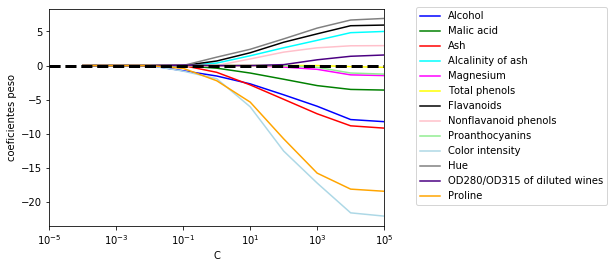

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()
ax = plt.subplot(111)
colors = ['blue', 'green', 'red', 'cyan',
          'magenta', 'yellow', 'black',
          'pink', 'lightgreen', 'lightblue',
          'gray', 'indigo', 'orange']
weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', C=10.**c,
                            solver='liblinear',
                            multi_class='ovr', random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)
weights = np.array(weights)
for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column + 1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('coeficientes peso')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center',
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
plt.show()

El gráfico resultante nos proporciona más información sobre el comportamiento de la regularización de L1. Como se puede ver, todos los pesos de las características serán cero si se penaliza el modelo con un parámetro de regularización fuerte (`C <0.01`);  `C` es el inverso del parámetro de regularización $\lambda$.

### Algoritmos secuenciales de selección de características ###
Una forma alternativa de reducir la complejidad del modelo y evitar el sobreajuste es la **reducción de dimensionalidad** a través de la selección de características, que es especialmente útil para modelos no regularizados. Hay dos categorías principales de **técnicas de reducción de dimensionalidad**: **selección de características** y **extracción de características**. Mediante la selección de características, seleccionamos un subconjunto de las características originales, mientras que en la extracción de características, derivamos información del conjunto de características para construir un nuevo subespacio de características.

Los algoritmos de **selección de características secuenciales** son una familia de **algoritmos de búsqueda ambiciosos** que se utilizan para reducir un espacio de características *d*-dimensionales iniciales a un subespacio de características *k*-dimensionales donde $k <d$. La motivación detrás de los algoritmos de selección de características es seleccionar automáticamente un subconjunto de características que son más relevantes para el problema, o para mejorar la eficiencia computacional, o para reducir el error de generalización del modelo al eliminar características irrelevantes o ruido, lo que puede ser útil para algoritmos que No son compatibles con la regularización.

> #### Algoritmos de búsqueda ambiciosos ####
> Los **algoritmos ambiciosos** hacen elecciones localmente óptimas en cada etapa de un problema de búsqueda combinatoria y generalmente brindan una solución subóptima al problema, en contraste con los **algoritmos de búsqueda exhaustivos**, que evalúan todas las combinaciones posibles y garantizan encontrar la solución óptima. Sin embargo, en la práctica, una búsqueda exhaustiva a menudo no es factible computacionalmente, mientras que los algoritmos codiciosos permiten una solución menos compleja y computacionalmente más eficiente.

Un algoritmo clásico de selección de características secuenciales es la **selección secuencial hacia atrás (SBS)**, cuyo objetivo es reducir la dimensionalidad del subespacio de características inicial con una disminución mínima en el rendimiento del clasificador para mejorar la eficiencia computacional. En ciertos casos, SBS puede incluso mejorar el poder predictivo del modelo si un modelo sufre de sobreajuste.

La idea detrás del algoritmo SBS es bastante simple: SBS elimina secuencialmente las características del subconjunto de características completas hasta que el nuevo subespacio de características contenga el número deseado de características. Para determinar qué característica se eliminará en cada etapa, necesitamos definir la **función de criterio**, $J$, que queremos minimizar.

